In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3
import sqlalchemy

In [7]:
engine = sqlalchemy.create_engine('sqlite:///JobData.db')

jobs = pd.read_sql('Select * FROM Jobs', engine, index_col='id')

jobs_salaries = pd.read_sql(""" Select
t1.id, t1.job_title, t1.company, t1.location, t2.salary_type, t2.salary_period, t2.expected, t2.floor, t2.ceiling 
FROM Jobs t1 INNER JOIN Salaries t2 ON t1.id = t2.id""", 
engine, index_col='id')

jobs_salaries_keywords = pd.read_sql(""" Select 
t1.id, t1.job_title, t1.company, t1.location, t2.salary_type, t2.salary_period, t2.expected, t2.floor, t2.ceiling, t3.keyword 
FROM Jobs t1 INNER JOIN Salaries t2 ON t1.id = t2.id LEFT JOIN KeywordRef t3 ON t3.id = t1.id""", 
engine, index_col=['id', 'keyword'])


In [8]:
jobs.head()

,job_title,company,location,rating_provided,rating,salary_provided,weblink,date_recorded,location_model,jurisdiction,city,country
id,,,,,,,,,,,,
cdc658d9990a63fc,Data Analyst (Banking Projects) - up to $62.00...,CorGTA Inc.,"Hybrid remote in Toronto, ON",n,NaN,y,https://ca.indeed.com/viewjob?jk=cdc658d9990a63fc,2023-11-17,Hybrid remote,ON,Toronto,Canada
cc8c9dc11f3c271f,"Business Analyst (Hybrid: North York, ON) - Re...",Enbridge Contingent Talent Community,"Hybrid remote in North York, ON",n,NaN,n,https://ca.indeed.com/viewjob?jk=cc8c9dc11f3c271f,2023-11-17,Hybrid remote,ON,North York,Canada
79507b61bd95323f,Pricing Analyst (FS/Tech/Furn),Staples Canada,"Mississauga, ON",n,NaN,n,https://ca.indeed.com/viewjob?jk=79507b61bd95323f,2023-11-17,Not Specified,ON,Mississauga,Canada
fb2e1282f0ec6e8e,Configuration Specialist/Functional Analyst,Procom,Remote in Ontario,n,NaN,n,https://ca.indeed.com/viewjob?jk=fb2e1282f0ec6e8e,2023-11-17,Remote,ON,Not Specified,Canada
1079d92e140e0d7f,Data Visualization Engineer,Motorola Solutions,"Remote in Markham, ON",n,NaN,y,https://ca.indeed.com/viewjob?jk=1079d92e140e0d7f,2023-11-17,Remote,ON,Markham,Canada


In [9]:
#In general, the data seems clean and effectively populated. Rating's are null if not provided from job which indicates rating is sparely populated on job board. 
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2920 entries, cdc658d9990a63fc to eff3eeac0c6a2f1e
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   job_title        2920 non-null   object 
 1   company          2920 non-null   object 
 2   location         2920 non-null   object 
 3   rating_provided  2920 non-null   object 
 4   rating           84 non-null     float64
 5   salary_provided  2920 non-null   object 
 6   weblink          2920 non-null   object 
 7   date_recorded    2920 non-null   object 
 8   location_model   2920 non-null   object 
 9   jurisdiction     2920 non-null   object 
 10  city             2920 non-null   object 
 11  country          2920 non-null   object 
dtypes: float64(1), object(11)
memory usage: 296.6+ KB


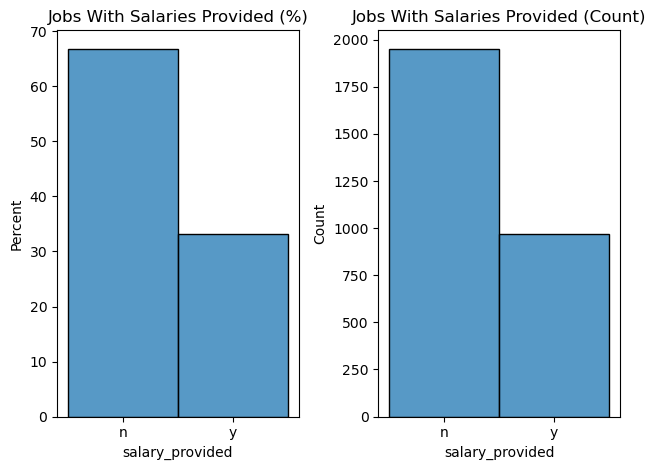

In [10]:
fig, axes = plt.subplots(1,2)

sns.histplot(data = jobs.sort_values(by = 'salary_provided'), x = 'salary_provided', stat = 'percent', ax=axes[0])
axes[0].set_title('Jobs With Salaries Provided (%)')

sns.histplot(data = jobs.sort_values(by = 'salary_provided'), x = 'salary_provided', ax=axes[1])
axes[1].set_title('Jobs With Salaries Provided (Count)')

plt.tight_layout()

plt.show()

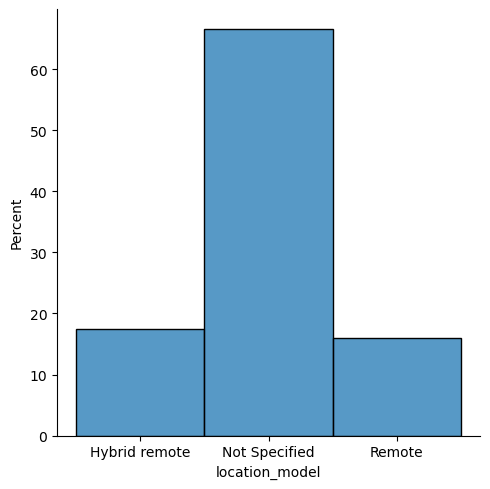

In [11]:
sns.displot(data = jobs, x = 'location_model', stat = 'percent')

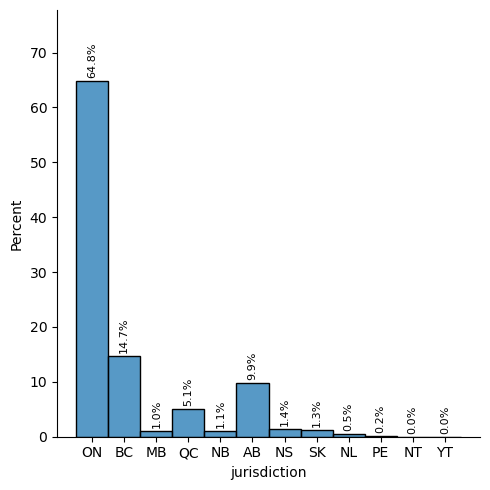

In [12]:
fg = sns.displot(data = jobs[jobs['jurisdiction'] != 'Not Specified'], x = 'jurisdiction', stat = 'percent')

for ax in fg.axes.ravel():
    for c in ax.containers:
        labels = [f'{v.get_height():0.1f}%' if v.get_height() > 0 else '' for v in c]

        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=90, padding=2)
    
    ax.margins(y=0.2)

plt.show()


In [13]:
jobs_jurisdiction_grouped = pd.DataFrame(jobs.groupby('jurisdiction').size(), columns = ['job_count'])
jobs_jurisdiction_grouped['job_count_perc'] = jobs_jurisdiction_grouped['job_count'] / jobs_jurisdiction_grouped['job_count'].sum() * 100

In [14]:
jobs_jurisdiction_grouped = jobs_jurisdiction_grouped[jobs_jurisdiction_grouped.index != 'Not Specified'].sort_values(by='job_count', ascending=False)

In [15]:
pop = pd.read_csv('Canada Population.csv', thousands=',', index_col = 'geography')

pop['population_perc'] = pop['population']/pop['population'].sum()*100

In [16]:
population_merged = pd.merge(left = jobs_jurisdiction_grouped, right = pop, how = 'inner', left_on=jobs_jurisdiction_grouped.index, right_on='jurisdiction').set_index('jurisdiction')[['job_count_perc','population_perc']]

In [17]:
population_merged

,job_count_perc,population_perc
jurisdiction,,
ON,59.828767,38.989374
BC,13.561644,13.770905
AB,9.109589,11.735989
QC,4.691781,22.079680
NS,1.267123,2.631281
SK,1.198630,3.007708
NB,1.027397,2.079345
MB,0.924658,3.615835
NL,0.479452,1.333431


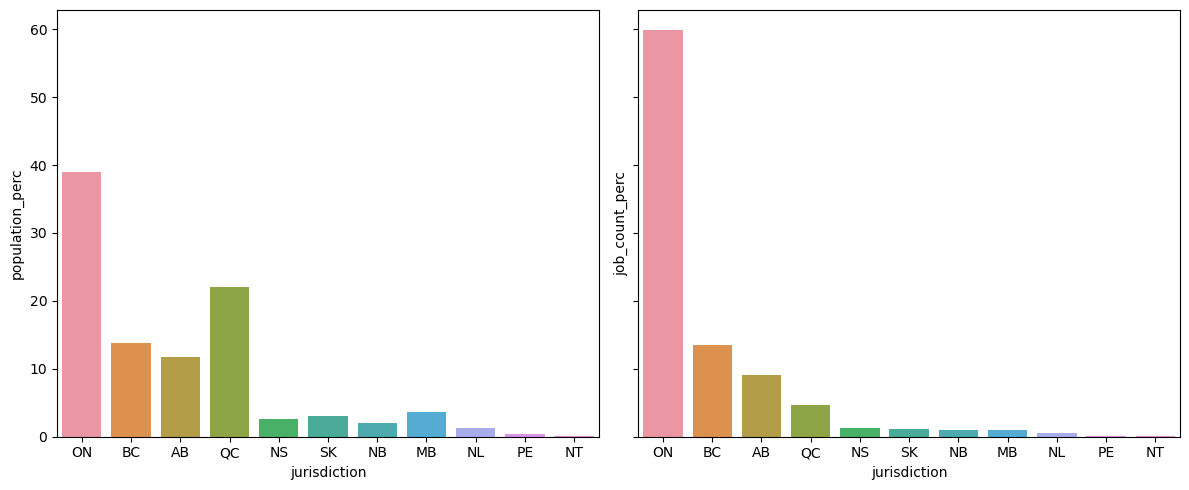

In [18]:
fig, axes = plt.subplots(1,2, figsize = (12,5), sharey=True)

sns.barplot(data = population_merged, x = population_merged.index, y = 'population_perc', ax=axes[0])

sns.barplot(data = population_merged, x = population_merged.index, y = 'job_count_perc', ax=axes[1])

plt.tight_layout()

plt.show()

In [19]:
population_merged.head()

,job_count_perc,population_perc
jurisdiction,,
ON,59.828767,38.989374
BC,13.561644,13.770905
AB,9.109589,11.735989
QC,4.691781,22.079680
NS,1.267123,2.631281


Text(0.5, 1.0, 'Comparison of Provincal Population (%) to Provincal Jobs Found (%)')

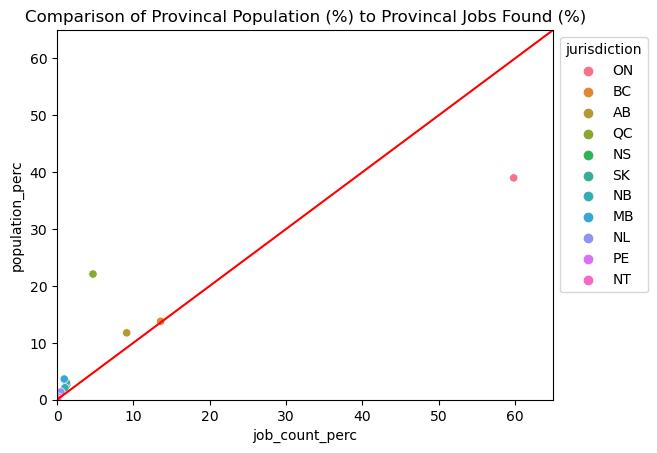

In [20]:
sns.scatterplot(data = population_merged, x='job_count_perc', y='population_perc', hue = population_merged.index)

axis_lim = 65

plt.xlim(0,axis_lim)
plt.ylim(0,axis_lim)

plt.plot([0,axis_lim], [0,axis_lim], color = 'red')

plt.legend(title='jurisdiction', bbox_to_anchor=(1, 1), loc='upper left')

plt.title(label="Comparison of Provincal Population (%) to Provincal Jobs Found (%)")


Was interested in the distribution of jobs found and what may be causing the difference between the number of jobs available in different provinces. Compared to the population distribution in provinces (named jurisdictions here) within the country first. This does explain a lot of the distribution of the jobs - provinces that fall near the diagonal line are close in terms of jobs found compared to relative province population. Ones that are higher than the line indicate a higher populaion relative to jobs found and vice versa for the jobs that fall below the diagonal line. There are a couple notable points that fall far from the line - Quebec and Ontario. 

Quebec has a relatively higher population relative to jobs found. Intuitively, this is likely due to the languauge of search being English and the primary language in Quebec being French. Some of this difference may be made up by Ontario. But regardless, Ontario seems to have a larger proportion of jobs relative to other provinces even ater accounting for population numbers. 

In [21]:
jobs_jurisdiction_salary_grouped =pd.DataFrame(jobs[jobs['jurisdiction']!='Not Specified'].groupby(by=['jurisdiction', 'salary_provided']).size(), columns=['job_count']).reset_index().sort_values('job_count', ascending=False)

jobs_jurisdiction_salary_grouped

,jurisdiction,salary_provided,job_count
13,ON,n,1258
14,ON,y,489
3,BC,y,238
0,AB,n,164
2,BC,n,158
17,QC,n,118
1,AB,y,102
10,NS,n,28
19,SK,n,21
18,QC,y,19


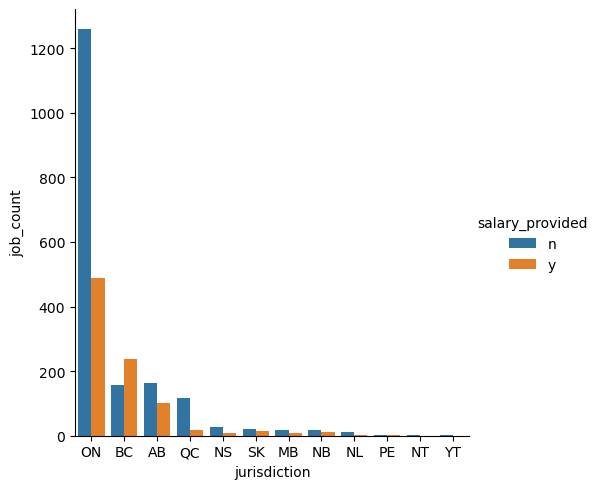

In [22]:
sns.catplot(data=jobs_jurisdiction_salary_grouped, kind = 'bar', 
            x = 'jurisdiction', 
            y = 'job_count',
            hue = 'salary_provided'
            )

Interestingly, although Ontario has a lot of job openings, they have a proportionally low number of jobs where the salaries are actually provided in the listings. BC stands out here being the only province with more jobs with salaries provided than not - and by a substantial margin as well. 

In [23]:
jobs_salaries = pd.read_sql(""" Select
t1.id, t1.job_title, t1.company, t1.location, t2.salary_type, t2.salary_period, t2.expected, t2.floor, t2.ceiling 
FROM Jobs t1 INNER JOIN Salaries t2 ON t1.id = t2.id""", 
engine, index_col='id')

In [24]:
jobs_salaries.head()

,job_title,company,location,salary_type,salary_period,expected,floor,ceiling
id,,,,,,,,
cdc658d9990a63fc,Data Analyst (Banking Projects) - up to $62.00...,CorGTA Inc.,"Hybrid remote in Toronto, ON",range,hourly,61.00,60.00,62.00
1079d92e140e0d7f,Data Visualization Engineer,Motorola Solutions,"Remote in Markham, ON",range,yearly,75000.00,70000.00,80000.00
fbaa0c742c9095f4,Senior Data Analyst,Basis Technologies,"Remote in Toronto, ON",range,yearly,114000.00,84000.00,144000.00
edb18d98d48fef48,Data Analyst,ATW International Inc.,"York, ON",range,yearly,69826.00,40740.00,98912.00
6e63fd5ee73b1053,Data Developer and Analyst,Loyalist College,"Remote in Belleville, ON",range,hourly,44.39,41.12,47.67


In [25]:
jobs_salaries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 968 entries, cdc658d9990a63fc to 156755c3658cab6d
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   job_title      968 non-null    object 
 1   company        968 non-null    object 
 2   location       968 non-null    object 
 3   salary_type    968 non-null    object 
 4   salary_period  968 non-null    object 
 5   expected       899 non-null    float64
 6   floor          672 non-null    float64
 7   ceiling        631 non-null    float64
dtypes: float64(3), object(5)
memory usage: 68.1+ KB


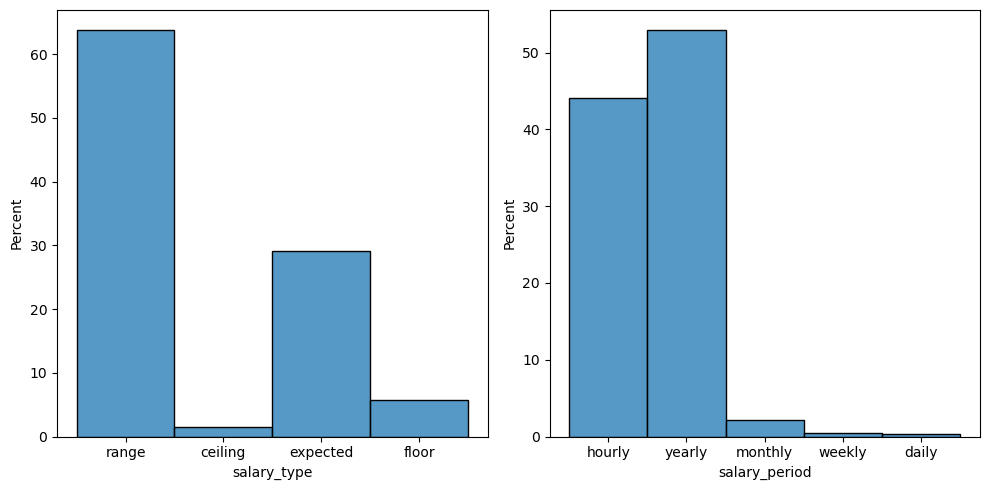

In [26]:
fig, axes = plt.subplots(1,2, figsize = (10,5))

sns.histplot(data = jobs_salaries, x = 'salary_type', stat = 'percent', ax = axes[0])

sns.histplot(data = jobs_salaries, x = 'salary_period', stat = 'percent', ax = axes[1])

plt.tight_layout()

The left plot shows that most of the jobs have a 'range' or an 'expected' salary type. Range, as the name suggests represents situations in which a salary range is provided in the job posting (ie. $30,000 - $40,000). The expected represents situations in which only a single salary value is provided. Floor and ceiling depict situations where job postings provide a single salary value, but also indicate that the value given represents the minimum salary value for the role (ie. "From $30,000) or the maximum salary value for the role (ie. "Up to $40,000). 

It is important to account for these situational differences in values provided to ensure comparisons are done on equal terms. In this analysis, an assumption is made that the range salary provided can be linerally interpolated between it's minimum and maximum values to provide a relatively accurate expected salary value. 

There are other assumptions that can be made related to the floor and ceiling salary values to try and approximate an expected value. However, such methods would would introduce additional approximation errors. Due to this and the fact that the ceiling and floor salary types represent a relatively small part of the total dataset (<10%), further analysis that compare different salaries will focus on the range and expected salary types only. 



The right plot shows that the majority of jobs with salaries provided do so at an hourly or yearly period. Similarily, since the monthly, weekly and daily periods are very rare (<5%), the remaining analysis focuses on the heavy hitters instead.  

In [27]:
jobs_salaries_keywords

job_title  \
id               keyword                                                                     
cdc658d9990a63fc data analyst            Data Analyst (Banking Projects) - up to $62.00...   
1079d92e140e0d7f data analyst                                  Data Visualization Engineer   
fbaa0c742c9095f4 business intelligence                                 Senior Data Analyst   
                 data analyst                                          Senior Data Analyst   
                 data scientist                                        Senior Data Analyst   
...                                                                                    ...   
d546fc6f846b826c data analyst                                                 Data Analyst   
f297e51de393c29c data analyst                                             RESEARCH ANALYST   
98b5980af93502cf data analyst                                         Supply Chain Analyst   
7d96c8b6d4946e94 business intelligence                             Human Resources Manager   
156755c3658cab6d database administrator   Front Desk Administrator Remote Sites (82912001)   

                                                          company  \
id               keyword                                            
cdc658d9990a63fc data analyst                         CorGTA Inc.   
1079d92e140e0d7f data analyst                  Motorola Solutions   
fbaa0c742c9095f4 business intelligence         Basis Technologies   
                 data analyst                  Basis Technologies   
                 data scientist                Basis Technologies   
...                                                           ...   
d546fc6f846b826c data analyst                              Procom   
f297e51de393c29c data analyst            Burkett Asset Management   
98b5980af93502cf data analyst                              dbrand   
7d96c8b6d4946e94 business intelligence     Para Space Landscaping   
156755c3658cab6d database administrator         Sodexo Canada Ltd   

                                                             location  \
id               keyword                                                
cdc658d9990a63fc data analyst            Hybrid remote in Toronto, ON   
1079d92e140e0d7f data analyst                   Remote in Markham, ON   
fbaa0c742c9095f4 business intelligence          Remote in Toronto, ON   
                 data analyst                   Remote in Toronto, ON   
                 data scientist                 Remote in Toronto, ON   
...                                                               ...   
d546fc6f846b826c data analyst                           Vancouver, BC   
f297e51de393c29c data analyst                            Victoria, BC   
98b5980af93502cf data analyst                         Mississauga, ON   
7d96c8b6d4946e94 business intelligence                    Burnaby, BC   
156755c3658cab6d database administrator        Remote in Edmonton, AB   

                                        salary_type salary_period   expected  \
id               keyword                                                       
cdc658d9990a63fc data analyst                 range        hourly      61.00   
1079d92e140e0d7f data analyst                 range        yearly   75000.00   
fbaa0c742c9095f4 business intelligence        range        yearly  114000.00   
                 data analyst                 range        yearly  114000.00   
                 data scientist               range        yearly  114000.00   
...                                             ...           ...        ...   
d546fc6f846b826c data analyst                 range        hourly      26.00   
f297e51de393c29c data analyst                 range        yearly   72500.00   
98b5980af93502cf data analyst                 range        yearly   80000.00   
7d96c8b6d4946e94 business intelligence        range        yearly  100000.00   
156755c3658cab6d database administrator    expecte

In [28]:
jobs_salaries_keywords_hourly = jobs_salaries_keywords[jobs_salaries_keywords['salary_period'] == 'hourly']
jobs_salaries_keywords_yearly = jobs_salaries_keywords[jobs_salaries_keywords['salary_period'] == 'yearly']

<Axes: xlabel='expected', ylabel='Count'>

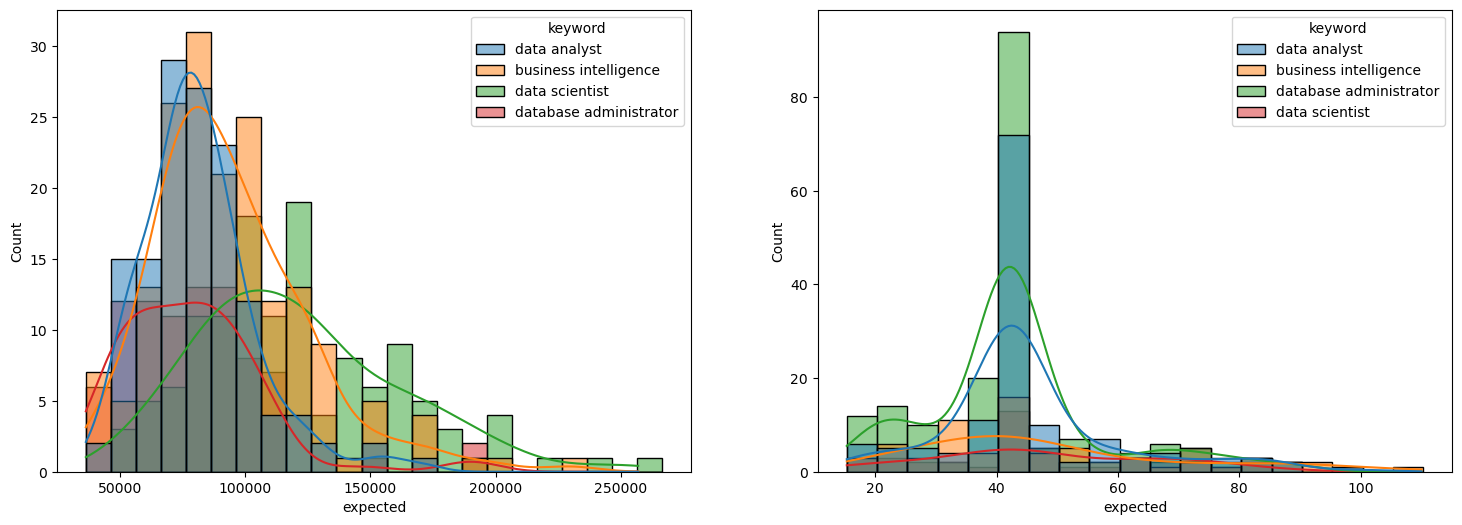

In [29]:
fig, axes = plt.subplots(1,2, figsize = (18,6))

sns.histplot(
    data = jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='yearly'], x='expected', hue = 'keyword', kde = True, binwidth = 10000, ax=axes[0])

sns.histplot(
    data = jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='hourly'], x='expected', hue = 'keyword', kde = True, binwidth = 5, ax=axes[1])

<Axes: xlabel='keyword', ylabel='expected'>

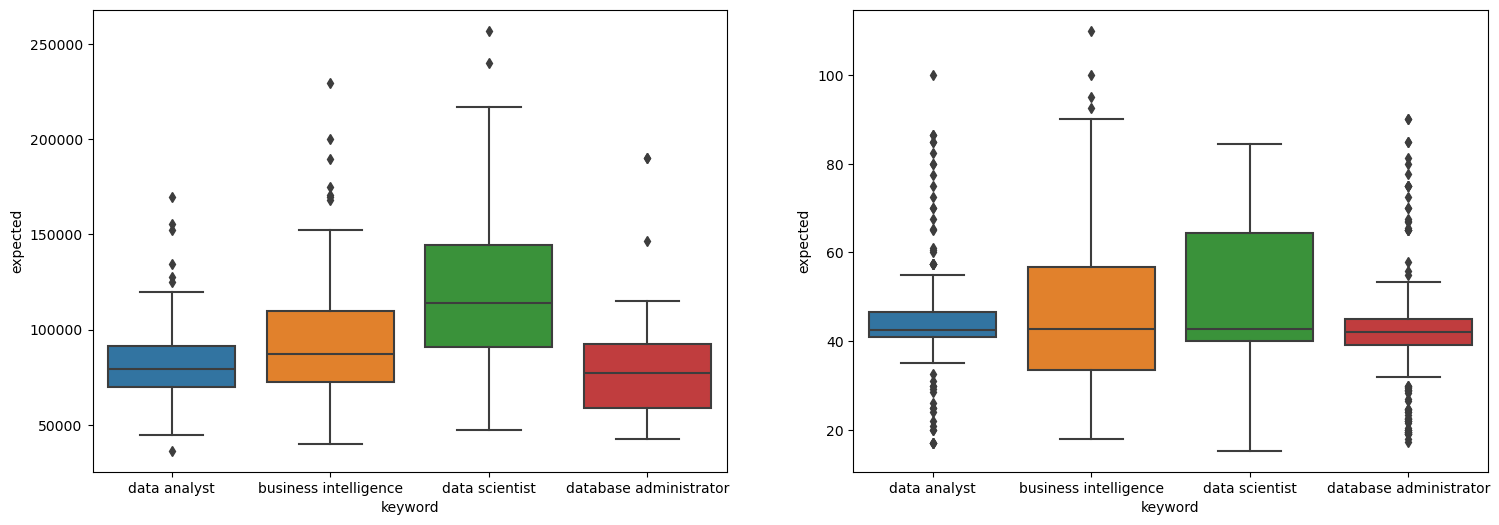

In [30]:
fig, axes = plt.subplots(1,2, figsize=(18,6))

x_order = jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='yearly'].reset_index()['keyword'].unique()

sns.boxplot(data = jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='yearly'].reset_index(), x='keyword', y='expected', ax=axes[0], order=x_order)

sns.boxplot(data = jobs_salaries_keywords[jobs_salaries_keywords['salary_period']=='hourly'].reset_index(), x='keyword', y='expected', ax=axes[1], order=x_order)